In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [45]:
def Motor(deg,N):
    kvs = 160*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    a,b,c,d,e,f=.3,1.,1.1,1.15,1.18,1.5
    th_m,th_air,th_fe=35.,2.,6. # 2*th_m + 4*th_air + 2*th_fe = 90!!!
    geos=[
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360),                                                 #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe

        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360),                                                 #M1
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Air
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Air
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #M2
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Air
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Air

        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360),                                                 #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe

        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360),                                                 #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Air
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Air

        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360),                                                 #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe
    ]

    Fe = {0,1,2,3,4,5,6,7,10,14,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38,39}
    Fe = set().union(*[{x + 40*i for x in Fe} for i in range(4)])
    Air={9,11,13,15,24,25,26,27,28,29,30,31}
    Air = set().union(*[{x + 40*i for x in Air} for i in range(4)])
    M1={8}
    M1 = set().union(*[{x + 40*i for x in M1} for i in range(4)])
    M2={12}
    M2 = set().union(*[{x + 40*i for x in M2} for i in range(4)])
    domains = {'M1':M1,'M2':M2,'Fe':Fe,'Air':Air}

    m=-20/360*2*pi
    geos = [g.rotate_2d(m) for g in geos] + [g.rotate_2d(pi/2+m) for g in geos] + [g.rotate_2d(pi+m) for g in geos] + [g.rotate_2d(3/2*pi+m) for g in geos]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    #patches = [(k, g) for k, g in zip(kvs,geos)]

    t=time.time()
    M = topology.PatchMesh(patches, domains=domains)
    print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
    return M
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

In [4]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': lambda x,y: 0.0, 'M2':lambda x,y: 0.0, 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

In [19]:
deg=2
M=Motor(deg,deg+1)
maxiter=8
MP_a, uh_a, numdofs_a, L2err_a, H1err_a, err_est, err_ind, refined, P = adaptive(M, nu=nu, j=j, Ma_T=Ma_T, theta=0.9, maxiter=maxiter, plotrange=(-1,1), draw=False)

Detecting interfaces took 11.747120141983032 seconds.
0


/tmp/ipykernel_4283/1419935161.py:42: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Residual contributions took 1.2271313667297363 seconds.
Jump contributions took 1.6347062587738037 seconds.
Estimate and Marking took 2.862593412399292 seconds.
Refinement took 1.3024499416351318 seconds.
Basis setup took 1.3024499416351318 seconds.
1
Residual contributions took 1.6369903087615967 seconds.
Jump contributions took 2.519238233566284 seconds.
Estimate and Marking took 4.1570634841918945 seconds.
Refinement took 2.7692699432373047 seconds.
Basis setup took 2.7692699432373047 seconds.
2
Residual contributions took 2.7076079845428467 seconds.
Jump contributions took 4.817103147506714 seconds.
Estimate and Marking took 7.525721311569214 seconds.
Refinement took 5.597181081771851 seconds.
Basis setup took 5.597181081771851 seconds.
3
Residual contributions took 4.768423318862915 seconds.
Jump contributions took 7.949089765548706 seconds.
Estimate and Marking took 12.719295740127563 seconds.
Refinement took 11.348535776138306 seconds.
Basis setup took 11.348535776138306 seconds

In [20]:
P

[<70780x2688 sparse matrix of type '<class 'numpy.float64'>'
 	with 907761 stored elements in Compressed Sparse Row format>,
 <70780x3448 sparse matrix of type '<class 'numpy.float64'>'
 	with 858661 stored elements in Compressed Sparse Row format>,
 <70780x5464 sparse matrix of type '<class 'numpy.float64'>'
 	with 736227 stored elements in Compressed Sparse Row format>,
 <70780x8988 sparse matrix of type '<class 'numpy.float64'>'
 	with 608332 stored elements in Compressed Sparse Row format>,
 <70780x14136 sparse matrix of type '<class 'numpy.float64'>'
 	with 490344 stored elements in Compressed Sparse Row format>,
 <70780x22520 sparse matrix of type '<class 'numpy.float64'>'
 	with 361072 stored elements in Compressed Sparse Row format>,
 <70780x40384 sparse matrix of type '<class 'numpy.float64'>'
 	with 214868 stored elements in Compressed Sparse Row format>]

In [21]:
P_a = MP_a.patch_refine(h_ref={},p_ref=1,return_P=True)

In [22]:
for i in range(len(P)):
    P[i]=P_a@P[i]

In [23]:
uh_a=P_a@uh_a

In [34]:
Mh_a = sum([MP_a.assemble_volume(vform.mass_vf(2),domain_id=k) for k in nu])
Kh_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2),domain_id=k) for k in nu])
Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])

In [36]:
deg=2
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
L2err=np.zeros(maxiter)
H1err=np.zeros(maxiter)
Aherr=np.zeros(maxiter)
numdofs=np.zeros(maxiter)

for i in range(len(refined)):
        bcs = MP.compute_dirichlet_bcs({0:0})
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        uh = LS.complete((cholesky(LS.A))(LS.b))
        
        eh=P[i]@uh-uh_a
        L2err[i] = sqrt(eh.T@Mh_a@eh)
        H1err[i] = sqrt(eh.T@Kh_a@eh + L2err[i]**2)
        Aherr[i] = sqrt(eh.T@Ah_a@eh)
        numdofs[i]=MP.numdofs
        if i < len(refined)-1:
            MP.patch_refine(h_ref=refined[i])

Detecting interfaces took 11.745513677597046 seconds.


/tmp/ipykernel_4283/3316316095.py:14: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


In [51]:
H1err

array([3.4144 , 3.45282, 3.17721, 2.71775, 1.98676, 1.20758, 0.95498, 0.     ])

In [55]:
numdofs

array([ 2688.,  3448.,  5464.,  8988., 14136., 22520., 40384.,     0.])

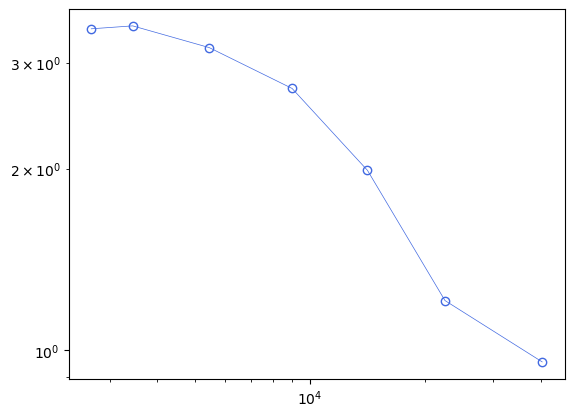

In [56]:
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')

NameError: name 'numdofs' is not defined

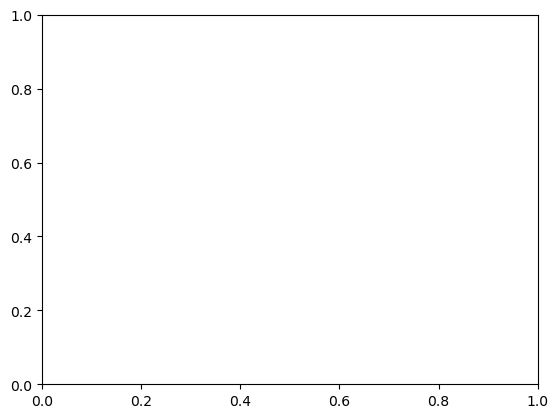

In [19]:
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')

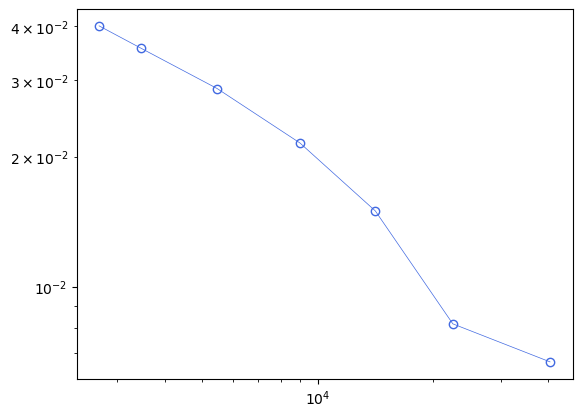

In [57]:
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')

In [53]:
Aherr

array([2477.32354, 2597.94347, 2451.30151, 2138.6329 , 1558.44613,  892.31074,  598.18162,    0.     ])

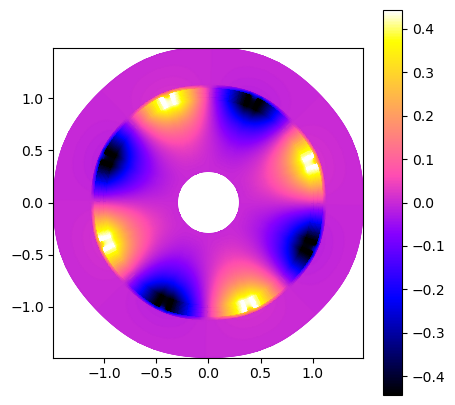

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [50]:
MP.plot(uh,cmap=plt.cm.gnuplot2)

In [37]:
numdofs

array([ 2688.,  3448.,  5464.,  8988., 14136., 22520., 40384.,     0.])

In [7]:
err=adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True)

residual contributions took 1.468482255935669 seconds.
jump contributions took 2.404148817062378 seconds.


In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [9]:
marked

[52, 132, 92, 12, 128, 8, 48, 88, 133, 13, 93, 53, 51]

Detecting interfaces took 10.848761081695557 seconds.


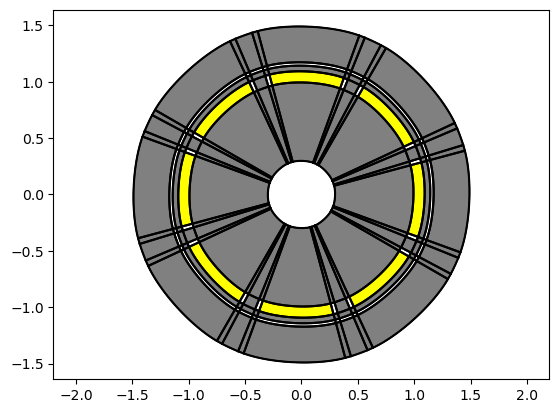

In [46]:
M=Motor(deg,deg+1)
M.draw(fig=plt.figure(),knots=False,color={'M1':'yellow', 'M2':'yellow','Fe':'grey','Air':'white'})
axis('equal');

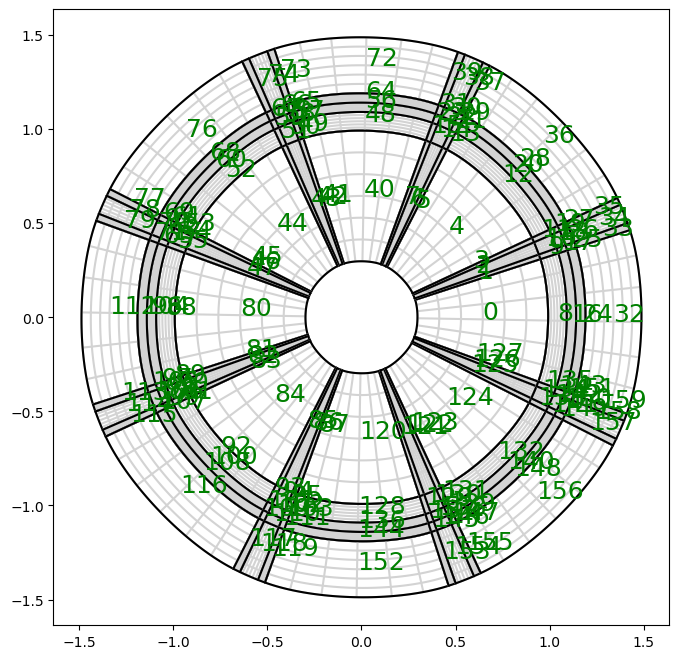

In [8]:
M.draw(patch_idx=True)
axis('scaled');

In [72]:
kvs, geo = M.patches[0][0]

In [73]:
F=assemble.assemble('inner(rho*nu*(-x[1],x[0]), grad(v)) * dx', kvs, arity=1, geo=geo, nu=nu['M1'], rho=1.28).ravel()

In [76]:
F.shape

(121,)

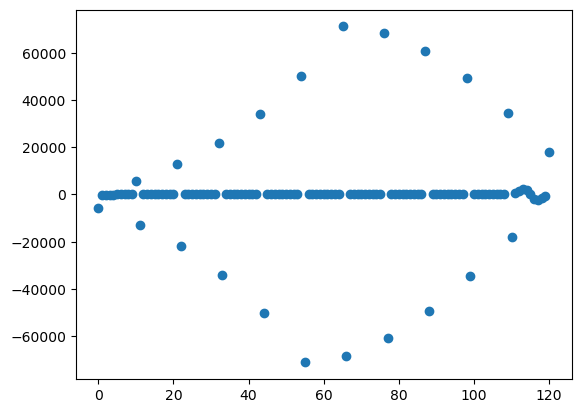

In [40]:
scatter(np.arange(len(F)),F)

In [65]:
vf = vform.VForm(2, arity=1)
v = vf.basisfuns()
M = vf.input('M')
vf.add(f * v * dx)

NameError: name 'dx' is not defined

In [2]:
M=topology.PatchMesh([(2*(bspline.make_knots(2,0.0,1.0,4),),geometry.unit_square())])
M.h_refine()
MP=assemble.Multipatch(M, automatch=True)

In [3]:
u_ = MP.L2projection(lambda x,y: x**2+y**2)

AttributeError: 'Figure' object has no attribute 'get_array'

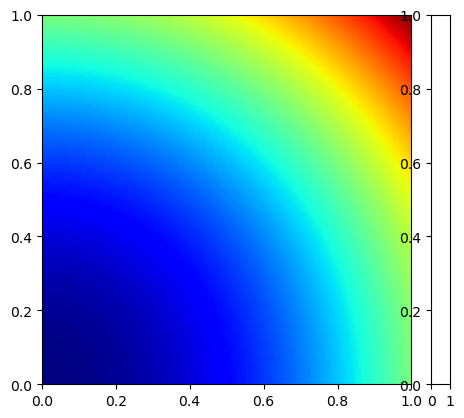

In [4]:
MP.plot(plt.figure(),u_)

In [5]:
fig=plt.figure()

<Figure size 640x480 with 0 Axes>